In [1]:
import pandas as pd
import os
from ast import literal_eval
import numpy as np

from spotipy.oauth2 import SpotifyClientCredentials
import json
import spotipy

import itertools
import networkx as nx
import math
from tqdm.notebook import tqdm

import torch
from torch_geometric.utils import to_networkx
from torch_geometric.data import HeteroData, Data
from torch_geometric.utils import degree

import networkx as nx

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Visualize snapshot graph

In [2]:
def from_edge_index_to_edgelist(edge_index, map_o, map_d, edge_type):
    edgelist=[]
    for i in range(len(edge_index[0])):
        o= edge_index[0][i]
        d= edge_index[1][i]
        
        o_name= map_o[o.item()]
        d_name= map_d[d.item()]
        edgelist.append((o_name,d_name,edge_type))
    
    return edgelist
        
def from_torch_data_to_dataframe(data, artist_map, song_map, genre_map):
    edgelist_all=[]
  
    #Filter artist_produce_song
    t= data["artist", "newproduce", "song"].edge_index.T
    artist_songs_df= pd.DataFrame(t.numpy())
    t2= data["artist", "newcollaborate", "artist"].edge_index.T
    df2= pd.DataFrame(t2.numpy())
    target_artists= set(df2[0].unique().tolist() + df2[1].unique().tolist())
    artist_songs_df= artist_songs_df[(artist_songs_df[0].isin(target_artists))]
    edge_index= torch.tensor(artist_songs_df.values).T
    edgelist_all += from_edge_index_to_edgelist(edge_index, artist_map, song_map, 'produce')                

    #Filter song_has_genre
    t= data["song", "newhas", "genre"].edge_index.T
    song_genres_df= pd.DataFrame(t.numpy())
    song_genres_df= song_genres_df.drop_duplicates(0, keep='first')
    target_songs= artist_songs_df[1].values#df2[1].unique().tolist()
    song_genres_df= song_genres_df[(song_genres_df[0].isin(target_songs))]
    edge_index= torch.tensor(song_genres_df.values).T    
    edgelist_all += from_edge_index_to_edgelist(edge_index, song_map, genre_map, 'has')
    
    #Filter artist_has_genre edges
    t= data["artist", "newhas", "genre"].edge_index.T
    artist_genres_df= pd.DataFrame(t.numpy())
    artist_genres_df= artist_genres_df.drop_duplicates(0, keep='first')
    t2= data["artist", "newcollaborate", "artist"].edge_index.T
    df2= pd.DataFrame(t2.numpy())
    target_artists= set(df2[0].unique().tolist() + df2[1].unique().tolist())
    artist_genres_df= artist_genres_df[(artist_genres_df[0].isin(target_artists))]
    edge_index= torch.tensor(artist_genres_df.values).T
    edgelist_all += from_edge_index_to_edgelist(edge_index, artist_map, genre_map, 'is')
    
    edge_index=data["artist", "newcollaborate", "artist"].edge_index
    edgelist_all +=from_edge_index_to_edgelist(edge_index, artist_map, artist_map, 'collaborate')
    
    df= pd.DataFrame(edgelist_all,columns='origin destination edge_type'.split())
    G=nx.from_pandas_edgelist(df, 'origin', 'destination', 'edge_type', create_using=nx.DiGraph)
    
    return G
    
def plot_snapshot_graph(G,  artist_list, track_list, genres_list, edges_types_to_plot,to_file=False, file_name=None):
    
    colour_map={}
    colour_map['collaborate']='red'
    colour_map['produce']='blue'
    colour_map['has']='green'
    colour_map['is']='black'
    
    val_map = {'artist': 1.0,
               'track': 0.5714285714285714,
               'genre': 0.0}
    
    
    G.remove_nodes_from(list(nx.isolates(G)))

    print("Defining layout...", end="")
    pos = nx.spring_layout(G, k=20/math.sqrt(G.order()));
    plt.figure(3,figsize=(20,20)) 
    print("DONE")
    
    print("Drawing nodes...", end="")
    color_list=[]
    for n in G.nodes():
        if n in artist_list:
            color_list.append(val_map['artist'])
        elif n in track_list:
            color_list.append(val_map['track'])
        else:
            color_list.append(val_map['genre'])
            
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('viridis'), node_color=color_list);
    print("DONE")
    
    for edge in tqdm(G.edges(data=True), desc="Drawing edges..."):
        if edge[2]['edge_type'] in edges_types_to_plot:
            nx.draw_networkx_edges(G, pos, edgelist=[edge], width=1.2, arrowsize=20, edge_color=colour_map[edge[2]['edge_type']])#, width=edge[2])
        
    #print("Drawing labels...", end="")
    #nx.draw_networkx_labels(G, pos, font_size=5, font_color='red')#, font_weight='bold')
    #print("DONE")
    
    plt.axis("off")
    
    if to_file:
        plt.savefig(os.path.join('figs',f'06_snapshot_G_{file_name}.png'), bbox_inches='tight')
    
    plt.show()

In [3]:
artist_info_df= pd.read_csv(os.path.join('data','generated', '04_lfm_spotify_artist_info_V2.csv'), 
                         converters={"genres": literal_eval}, index_col=0)
artist_info_df= artist_info_df.dropna(axis=0)
artist_info_df= artist_info_df.reset_index(drop=True)
artist_info_df

,artist_code,artist_name,popularity,followers,genres
0,2d6NCBac0YDM7UthnFGPYz,Strumparnir,19,641.0,[pop]
1,1XVbGKrwpq5PkEbOX2z5mg,Lay Down Rotten,5,2288.0,"[german, metal]"
2,4zMX9gWf1DKhvsYHUCbBF7,T Bone Burnett,31,28844.0,[rock]
3,2eJkpFtB62y7qCx27DDNGY,Dome,10,2219.0,[british]
4,6XUNUZVWpFql1ysNCVvsNS,Daniel Tosh,42,6829.0,[]
...,...,...,...,...,...
259693,4NOgfZ4g8sFOjffbwT9qee,MAD MONSTER,5,667.0,[]
259694,3CZ6FxLtgdyxJgMufi2M8w,Adecvat_production,31,1346.0,[pop]
259695,41sqYvXOn3ATsAQ65G1zx6,María Parrado,41,52785.0,[]
259696,1JOZiF1pKROyjz9YGTCpAc,Hienpuicakiiis,0,635.0,[]


In [4]:
artists_map= artist_info_df['artist_name'].to_dict()

In [5]:
genres_map={}
counter=0
for g_lst in artist_info_df['genres']:
    for g in g_lst:
        if g not in genres_map:
            genres_map[counter]= g
            counter = counter +1
genres_map

{0: 'pop',
 1: 'german',
 2: 'metal',
 3: 'rock',
 4: 'british',
 5: 'rock',
 6: 'pop',
 7: 'alternative',
 8: 'country',
 9: 'singer-songwriter',
 10: 'pop rock',
 11: 'rock',
 12: 'rock',
 13: 'alternative',
 14: 'metal',
 15: 'rock',
 16: 'french',
 17: 'folk',
 18: 'indie',
 19: 'german',
 20: 'jazz',
 21: 'rock',
 22: 'garage',
 23: 'punk',
 24: 'metal',
 25: 'rock',
 26: 'spanish',
 27: 'pop',
 28: 'rock',
 29: 'industrial',
 30: 'alternative',
 31: 'rap',
 32: 'metal',
 33: 'rock',
 34: 'anime',
 35: 'hip-hop',
 36: 'rap',
 37: 'dance',
 38: 'pop',
 39: 'rock',
 40: 'folk',
 41: 'french',
 42: 'metal',
 43: 'rock',
 44: 'alternative',
 45: 'jazz',
 46: 'rock',
 47: 'indie',
 48: 'german',
 49: 'alternative',
 50: 'hip-hop',
 51: 'soul',
 52: 'pop',
 53: 'hip-hop',
 54: 'rock',
 55: 'anime',
 56: 'punk',
 57: 'emo',
 58: 'pop',
 59: 'classical',
 60: 'folk',
 61: 'metal',
 62: 'proto-metal',
 63: 'cyberpunk',
 64: 'futurepop',
 65: 'pop',
 66: 'punk',
 67: 'blues',
 68: 'rock',
 

In [6]:
init_date='2004-01-01'
final_date='2021-12-31'
tracks_info= pd.read_csv(os.path.join('data', 'generated', '05b_all_tracks_w_feat_and_genre.csv'),
                         converters={"artist_id": literal_eval, 'artist_name': literal_eval, 'genres':literal_eval}, 
                         parse_dates=['release_date'],
                         index_col=0)
tracks_info= tracks_info[(tracks_info['release_date']>init_date) & (tracks_info['release_date']<=final_date)]
tracks_info= tracks_info[tracks_info['num_genres']>0]

tracks_info= tracks_info.reset_index(drop=True)
tracks_info['num_artists']= tracks_info['artist_id'].apply(lambda x:len(x))
track_map= tracks_info['track_id'].to_dict()
track_map

{0: '0yZPKwpGqeStYYjiRNTcPu',
 1: '4ak7xjvBeBOcJGWFDX9w5n',
 2: '3b7OgfU9SY8C7YBJgTKS74',
 3: '2syhl7N2qR4IwhlI7vy5HP',
 4: '5Q0af66iZwvAvN1LiayTNJ',
 5: '5ZbcYWBQWoCpuVip1fmeMY',
 6: '4nBcGqwztDJ29cyHVJtXsB',
 7: '1aj1Y2wG82EsnYVJXE5Bhn',
 8: '0fcq51a3gOI6gPvzc0YLsk',
 9: '38QKJTzaFlztlSViXASTpm',
 10: '3fSps53A2agi4sDU84AEmQ',
 11: '1Rt8bwO4rqGvgA1UWM1QXx',
 12: '3T00mhdOYUuM5yiuPs3xhs',
 13: '3tDqEKKUs6gf8zMvSuLyLA',
 14: '0vHFLAbbWuONECX3WCeXk1',
 15: '7iHHxY2NLlJRAmlAmC4ahQ',
 16: '5aXgz1oKK8Q9z9xvTmSnrO',
 17: '0afpbPmRHldjP59YRslQz9',
 18: '2y3qRsc49ZmSatwK1SVLFi',
 19: '0zfTyERIQHbtF5ywMHgSvV',
 20: '1vvnYpYEMVB4aq9I6tHIEB',
 21: '4tLmydpixuaZDtvOoSa54z',
 22: '4at3d5QWnlibMVN75ECDrp',
 23: '7v794i8wsqogD3AaaTH4wk',
 24: '0fHqGVs897kRSCPiWBgiNc',
 25: '4q8RrFOoW4RqbvxN24IfGY',
 26: '26KJQ9y0G4lbsTKvOgHcgX',
 27: '3AW6V6zWH45jI7eNPnSDfT',
 28: '1emWPsHEW8EEnHC75UDjSc',
 29: '6vn5wV2qwx5sengy1kZHnJ',
 30: '1wpbmqF1IFW1W1Zut5aquK',
 31: '7C5pur4EKhyZxUaUa9qxjQ',
 32: '4yoQbSPoj8H3

In [7]:
T= 12
T_size=6
time_window_size= 30 #days

graph_data_path=os.path.join('data', 'generated', 'graphs_V4', f'full_dataset_W_{time_window_size}_T_{T}_T_size_{T_size}.graph')
daily_dataset= torch.load(graph_data_path)

In [8]:
snapshot_to_plot=0

In [9]:
data=daily_dataset['edges'][snapshot_to_plot]

In [10]:
data

HeteroData(
  (artist, newcollaborate, artist)={
    edge_index=[2, 262],
    edge_label=[262, 1]
  },
  (artist, newproduce, song)={
    edge_index=[2, 1514],
    edge_label=[1514, 1]
  },
  (artist, newhas, genre)={
    edge_index=[2, 202759],
    edge_label=[202759, 1]
  },
  (song, newhas, genre)={
    edge_index=[2, 2449],
    edge_label=[2449, 1]
  },
  (artist, collaborate, artist)={
    edge_index=[2, 262],
    edge_label=[262, 1]
  },
  (artist, produce, song)={
    edge_index=[2, 1514],
    edge_label=[1514, 1]
  },
  (artist, has, genre)={
    edge_index=[2, 202759],
    edge_label=[202759, 1]
  },
  (song, has, genre)={
    edge_index=[2, 2449],
    edge_label=[2449, 1]
  },
  (artist, targetcollaborate, artist)={
    edge_index=[2, 2586],
    edge_label=[2586, 1]
  },
  (artist, rev_newcollaborate, artist)={
    edge_index=[2, 262],
    edge_label=[262, 1]
  },
  (song, rev_newproduce, artist)={
    edge_index=[2, 1514],
    edge_label=[1514, 1]
  },
  (genre, rev_newhas, 

In [11]:
G= from_torch_data_to_dataframe(data, artists_map, track_map, genres_map)
G, G.order(), G.number_of_nodes()

(<networkx.classes.digraph.DiGraph at 0x7f451e20bf70>, 305, 305)

Defining layout...DONE
Drawing nodes...DONE


Drawing edges...:   0%|          | 0/672 [00:00<?, ?it/s]

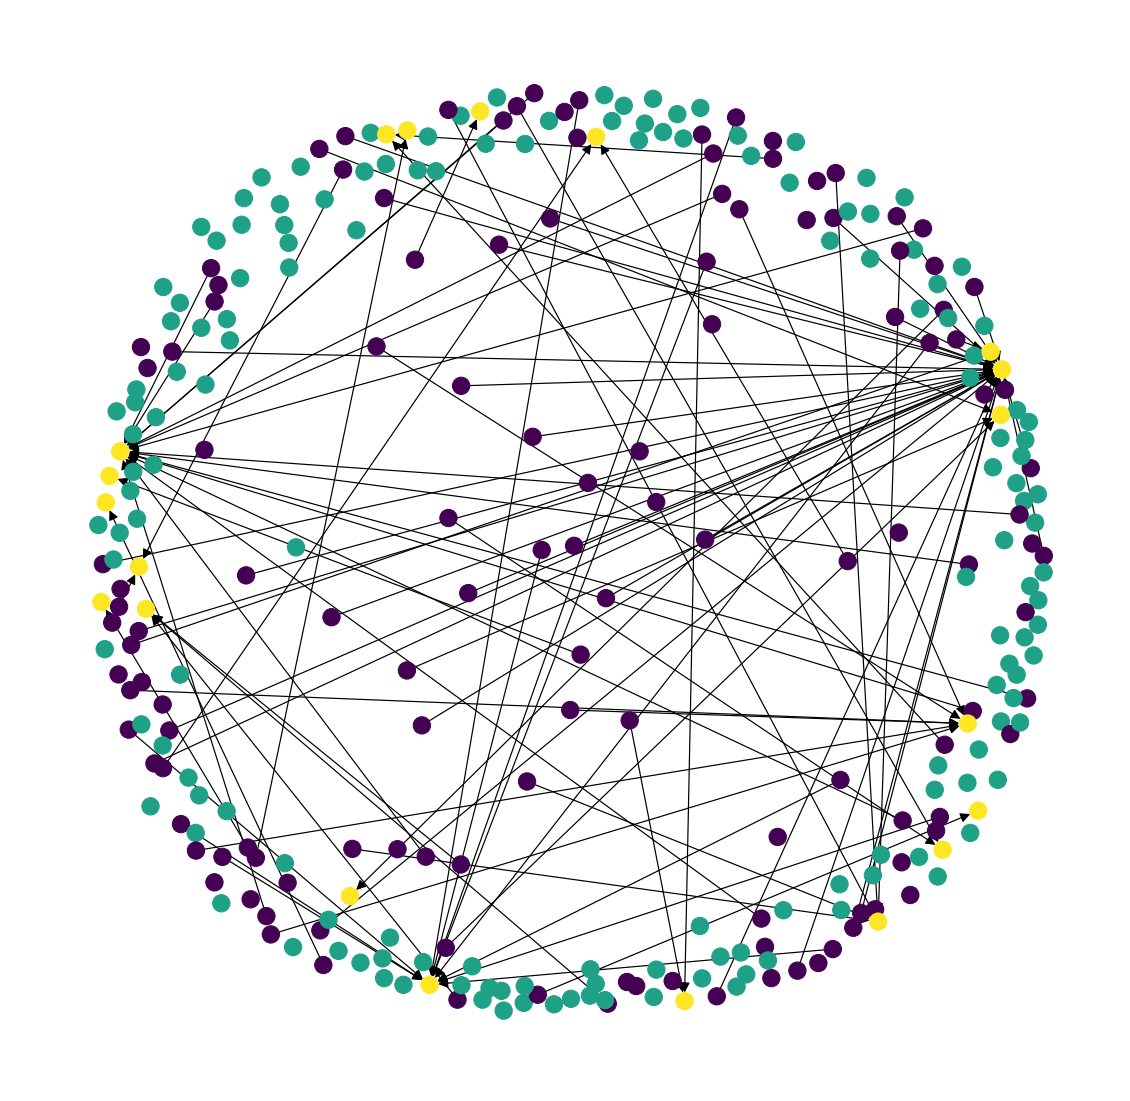

"\n    colour_map['collaborate']='red'\n    colour_map['produce']='blue'\n    colour_map['has']='green'\n    colour_map['is']='black'\n"

In [12]:
genres_list= list(genres_map.values())
artist_list= list(genres_map.values())
track_list= list(track_map.values())

target_edge_type='is'

plot_snapshot_graph(G, artist_list, track_list, genres_list, target_edge_type.split(), to_file=True, file_name=f'{snapshot_to_plot}_{target_edge_type}')
#Artists yellow, genres dark blue, tracks green

"""
    colour_map['collaborate']='red'
    colour_map['produce']='blue'
    colour_map['has']='green'
    colour_map['is']='black'
"""

### Read other input files

In [13]:
artist_info= pd.read_csv(os.path.join('data','generated', '04_lfm_spotify_artist_info_V2.csv'), 
                         converters={"genres": literal_eval}, index_col=0)
artist_info= artist_info.set_index('artist_code')
artist_info

,artist_name,popularity,followers,genres
artist_code,,,,
2d6NCBac0YDM7UthnFGPYz,Strumparnir,19,641.0,[pop]
1XVbGKrwpq5PkEbOX2z5mg,Lay Down Rotten,5,2288.0,"[german, metal]"
4zMX9gWf1DKhvsYHUCbBF7,T Bone Burnett,31,28844.0,[rock]
2eJkpFtB62y7qCx27DDNGY,Dome,10,2219.0,[british]
6XUNUZVWpFql1ysNCVvsNS,Daniel Tosh,42,6829.0,[]
...,...,...,...,...
4NOgfZ4g8sFOjffbwT9qee,MAD MONSTER,5,667.0,[]
3CZ6FxLtgdyxJgMufi2M8w,Adecvat_production,31,1346.0,[pop]
41sqYvXOn3ATsAQ65G1zx6,María Parrado,41,52785.0,[]


In [14]:
tracks_info= pd.read_csv(os.path.join('data', 'generated', '05b_all_tracks_w_feat_and_genre.csv'),
                         converters={"artist_id": literal_eval, 'artist_name': literal_eval}, 
                         parse_dates=['release_date'],
                         index_col=0)
tracks_info['num_artists']= tracks_info['artist_id'].apply(lambda x:len(x))
tracks_info

,track_id,release_date,release_date_precision,artist_id,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genres,num_genres,genres_str,num_artists
0,0yZPKwpGqeStYYjiRNTcPu,2017-05-05,day,[11wRdbnoYqRddKBrpHt4Ue],[Kasabian],0.511,0.9430,9.0,-4.276,1.0,0.0647,0.000151,0.000002,0.1610,0.5750,122.967,"['rock', 'garage', 'pop', 'alternative', 'indie']",5,";rock,garage,pop,alternative,indie",1
1,4ak7xjvBeBOcJGWFDX9w5n,2019-06-21,day,"[7jVv8c5Fj3E9VhNjxT4snq, 4kYSro6naA4h99UJvo89HB]","[Lil Nas X, Cardi B]",0.706,0.6790,9.0,-5.614,1.0,0.0324,0.139000,0.000070,0.4650,0.6570,140.081,"['rap', 'dance', 'pop']",3,";rap,dance,pop",2
2,3b7OgfU9SY8C7YBJgTKS74,2017-03-06,day,[2hcsKca6hCfFMwwdbFvenJ],[BTOB],0.696,0.9090,5.0,-3.547,0.0,0.0695,0.311000,0.000000,0.4660,0.6450,117.010,['k-pop'],1,;k-pop,1
3,2syhl7N2qR4IwhlI7vy5HP,2018-02-23,day,[62zLrboqOTPyozwi721CVy],[Lorenzo],0.845,0.6140,6.0,-5.830,1.0,0.3640,0.238000,0.000000,0.0969,0.3280,139.682,"['hip-hop', 'rap', 'french', 'pop']",4,";hip-hop,rap,french,pop",1
4,5Q0af66iZwvAvN1LiayTNJ,2017-01-13,day,[02G0wSA5mAINnHX3nTCaHi],[Baustelle],0.544,0.6110,9.0,-6.574,1.0,0.0351,0.238000,0.050600,0.0895,0.0485,111.900,"['alternative', 'indie', 'pop']",3,";alternative,indie,pop",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966719,5k2N84tO7V39kmWqMBku1T,1968-11-01,day,[7FIoB5PHdrMZVC3q2HE5MS],[George Harrison],0.136,0.0753,10.0,-22.024,1.0,0.0371,0.966000,0.409000,0.1100,0.0396,83.671,"['rock', 'folk', 'singer-songwriter']",3,";rock,folk,singer-songwriter",1
1966720,4KFIL87itsaRlSdCO1SKVg,2019-05-08,day,[086jKULFviWvDwM4evJgIP],[Josephine Wiggs],0.506,0.1120,0.0,-18.450,1.0,0.0417,0.945000,0.961000,0.1020,0.0447,91.992,[],0,;,1
1966721,4yu9BIIY5Cn9a9JfyZ4y22,2010-02-16,day,[3ViZST9PgFoieuOHY2GZMp],[Bear Hands],0.653,0.4590,0.0,-11.858,1.0,0.0399,0.082200,0.052800,0.4490,0.7000,91.998,"['rock', 'alternative', 'indie', 'pop']",4,";rock,alternative,indie,pop",1
1966722,7HHgPfm3p5dlQpwLLTjUQT,2009-11-23,day,[4tX2TplrkIP4v05BNC903e],[Tom Petty and the Heartbreakers],0.661,0.6490,2.0,-6.777,0.0,0.0340,0.623000,0.000000,0.9750,0.7320,114.477,"['rock', 'folk', 'pop', 'singer-songwriter', '...",5,";rock,folk,pop,singer-songwriter,pop rock",1


In [15]:
single_tracks= tracks_info[tracks_info['num_artists']==1]
collab_tracks= tracks_info[tracks_info['num_artists']>1]

### Compute number of artists with any collaboration

In [16]:
total_artists= set()
for i, track in tqdm(tracks_info.iterrows()):
    for a in track['artist_id']:
        total_artists.add(a)
        
print(len(total_artists))

0it [00:00, ?it/s]

261742


In [17]:
total_artists_w_collab= set()
for i, track in tqdm(collab_tracks.iterrows()):
    for a in track['artist_id']:
        total_artists_w_collab.add(a)
        
print(len(total_artists_w_collab))

0it [00:00, ?it/s]

132692


In [18]:
rate_artist_w_collab= len(total_artists_w_collab) / len(total_artists)
print(f'The rate of singers with at least one collaboration is :{rate_artist_w_collab*100}%')

The rate of singers with at least one collaboration is :50.69572326947911%


### Analyse temporal distribution of tracks

In [19]:
tracks_info['release_month']= tracks_info['release_date'].apply(lambda x: x.month)
tracks_info['release_year']= tracks_info['release_date'].apply(lambda x: x.year)
single_tracks= tracks_info[tracks_info['num_artists']==1]
collab_tracks= tracks_info[tracks_info['num_artists']>1]

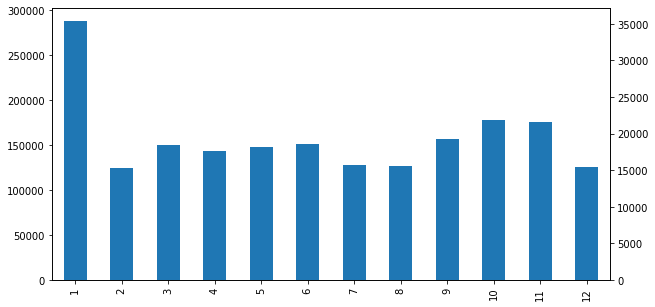

In [20]:
fig, ax = plt.subplots(figsize=(20,10)) 

ax= single_tracks['release_month'].value_counts().sort_index().plot(kind='bar', figsize=(10,5), grid=True)
collab_tracks['release_month'].value_counts().sort_index().plot(kind='bar', secondary_y=True, ax=ax);

<AxesSubplot:>

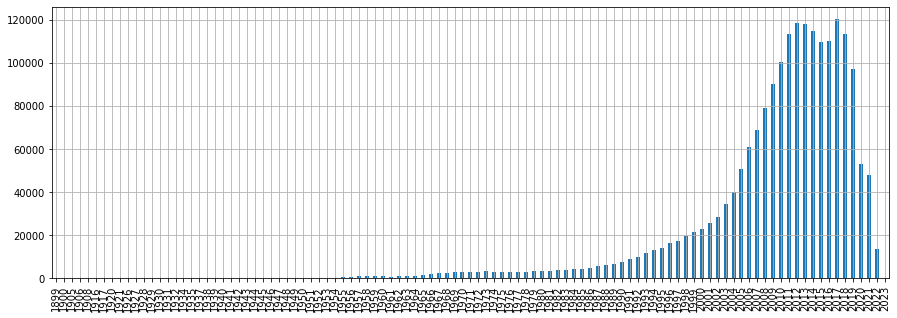

In [21]:
tracks_info['release_year'].value_counts().sort_index().plot(kind='bar', figsize=(15,5), grid=True)

In [22]:
n_single_tracks_per_month= single_tracks['release_month'].value_counts().sort_index().to_frame()
n_collab_tracks_per_month= collab_tracks['release_month'].value_counts().sort_index().to_frame()
n_tracks_per_month= n_single_tracks_per_month.copy()
n_tracks_per_month= n_tracks_per_month.rename(columns={'release_month':'Num. single'})
n_tracks_per_month['Num. collaborations']= n_collab_tracks_per_month

In [23]:
n_tracks_per_month

,Num. single,Num. collaborations
1,287995,35362
2,119691,15368
3,142747,18506
4,140479,17610
5,139520,18243
6,134425,18616
7,110677,15712
8,112418,15637
9,153355,19266
10,166753,21924


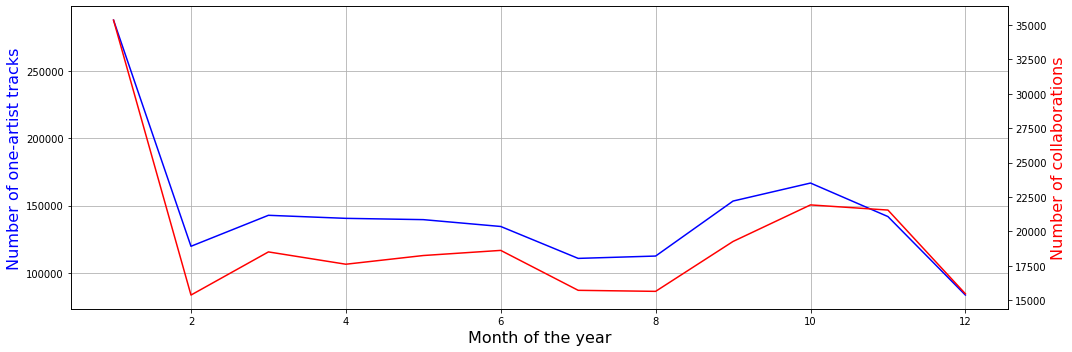

In [24]:
fig = plt.figure(figsize=(15,5)) 
ax = fig.add_subplot(111) # Create matplotlib axes

ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

n_tracks_per_month['Num. single'].plot(ax= ax, grid=True, color='blue')
n_tracks_per_month['Num. collaborations'].plot(color='red',ax= ax2);

ax.set_ylabel('Number of one-artist tracks', fontsize=16, color='blue');
ax.set_xlabel('Month of the year', fontsize=16);
ax2.set_ylabel('Number of collaborations', fontsize=16, color='red');
plt.tight_layout()
plt.savefig(os.path.join('figs',f'06_evolution_num_collaborations.png'), bbox_inches='tight')

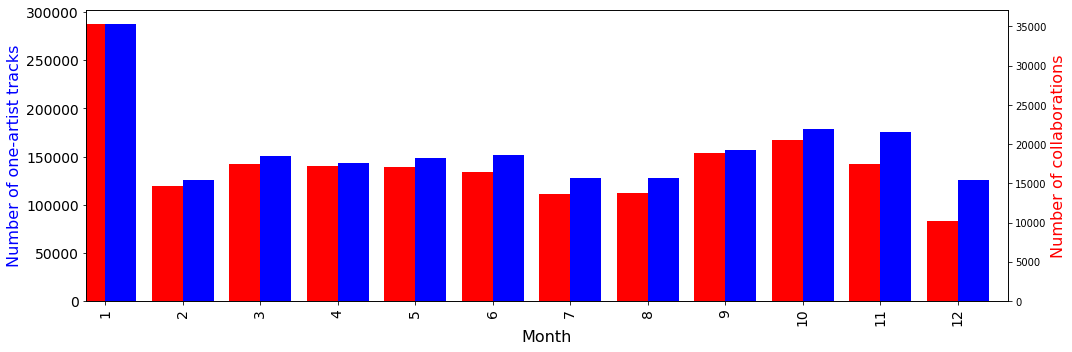

In [25]:
fig = plt.figure(figsize=(15,5)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
width = 0.4

n_tracks_per_month['Num. single'].plot(kind='bar', color='red', ax=ax, width=width, position=1, fontsize=14)
n_tracks_per_month['Num. collaborations'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_xlabel('Month', fontsize=16)

ax.set_ylabel('Number of one-artist tracks', fontsize=16, color='blue')
ax2.set_ylabel('Number of collaborations', fontsize=16, color='red')

plt.tight_layout()
plt.savefig(os.path.join('figs',f'06_evolution_num_collaborations_V2.png'), bbox_inches='tight')
plt.show()

In [26]:
n_single_tracks_per_year= single_tracks['release_year'].value_counts().sort_index().to_frame()
n_collab_tracks_per_year= collab_tracks['release_year'].value_counts().sort_index().to_frame()
n_tracks_per_year= n_single_tracks_per_year.copy()
n_tracks_per_year= n_tracks_per_year.rename(columns={'release_year':'Num. single'})
n_tracks_per_year['Num. collaborations']= n_collab_tracks_per_year

In [27]:
n_tracks_per_year.loc[2010:]

,Num. single,Num. collaborations
2010,92630,7865.0
2011,103132,10136.0
2012,106773,11585.0
2013,106086,11992.0
2014,101811,12901.0
2015,95487,14112.0
2016,94901,15128.0
2017,100028,20007.0
2018,91835,21604.0
2019,76764,20243.0


In [28]:
n_tracks_per_year['collab_rate']= n_tracks_per_year['Num. collaborations'] / n_tracks_per_year['Num. single']

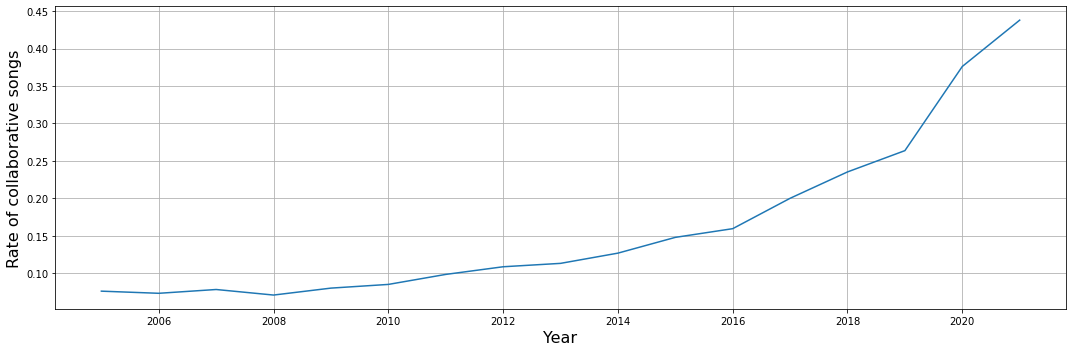

In [29]:
ax=n_tracks_per_year.loc[2005:2021]['collab_rate'].plot(grid=True, figsize=(15,5));
ax.set_ylabel('Rate of collaborative songs', fontsize=16);
ax.set_xlabel('Year', fontsize=16);
plt.tight_layout()
plt.savefig(os.path.join('figs',f'06_evolution_num_collaborations_V3.png'), bbox_inches='tight')

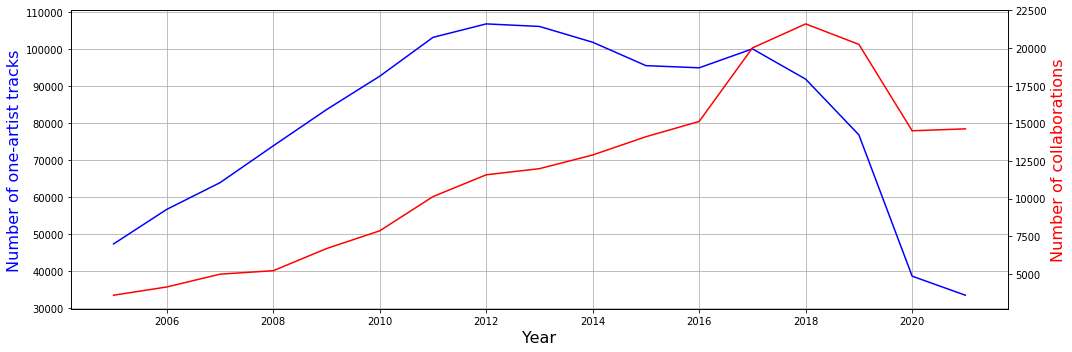

In [30]:
fig = plt.figure(figsize=(15,5)) 
ax = fig.add_subplot(111) # Create matplotlib axes

ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

n_tracks_per_year.loc[2005:2021]['Num. single'].plot(ax= ax, grid=True, color='blue')
n_tracks_per_year.loc[2005:2021]['Num. collaborations'].plot(color='red',ax= ax2);

ax.set_ylabel('Number of one-artist tracks', fontsize=16, color='blue');
ax.set_xlabel('Year', fontsize=16);
ax2.set_ylabel('Number of collaborations', fontsize=16, color='red');
plt.tight_layout()
plt.savefig(os.path.join('figs',f'06_evolution_num_collaborations_V4.png'), bbox_inches='tight')

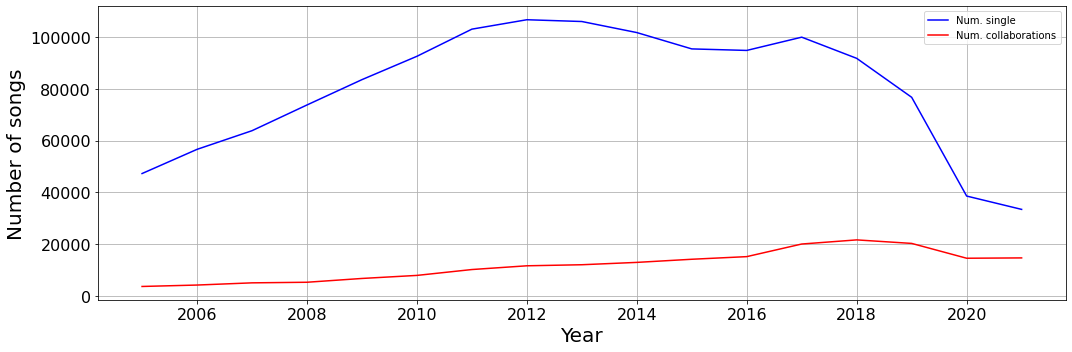

In [36]:
fig = plt.figure(figsize=(15,5)) 
ax = fig.add_subplot(111) # Create matplotlib axes

#ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

n_tracks_per_year.loc[2005:2021]['Num. single'].plot(ax= ax, grid=True, color='blue', legend=True)
n_tracks_per_year.loc[2005:2021]['Num. collaborations'].plot(color='red',ax= ax, grid=True, legend=True, fontsize=16);

ax.set_ylabel('Number of songs', fontsize=20);
ax.set_xlabel('Year', fontsize=20);
#ax2.set_ylabel('Number of collaborations', fontsize=16, color='red');
plt.tight_layout()
plt.savefig(os.path.join('figs',f'06_evolution_num_collaborations_V5.png'), bbox_inches='tight')

### Analyze collocation of genres per artist

In [31]:
def keep_largest_value(df):
    df_weights= df.max(axis=1).to_frame()
    df_tuples= df.idxmax(axis=1).to_frame()
    df_tuples['count']=df_weights
    
    largest_values_df= pd.DataFrame(0, columns=df.index, index= df.index)
    
    for i, values in df_tuples.iterrows():
        g1= i
        g2= values[0]
        weight= values['count']
        largest_values_df.loc[g1,g2]=weight
        
    largest_values_df= largest_values_df.sort_index()
    return largest_values_df

In [32]:
artist_genres_collocation={}

for i,artist in tqdm(artist_info.iterrows()):
    genres = artist['genres']
    for g1,g2 in list(itertools.combinations(genres, 2)):
        collocated_genres= artist_genres_collocation.get(g1,{})
        n_collocations= collocated_genres.get(g2,0) +1
        collocated_genres[g2]= n_collocations
        artist_genres_collocation[g1]= collocated_genres
        
        collocated_genres= artist_genres_collocation.get(g2,{})
        n_collocations= collocated_genres.get(g1,0) +1
        collocated_genres[g1]= n_collocations
        artist_genres_collocation[g2]= collocated_genres
        
        
artist_genres_collocation_df= pd.DataFrame(artist_genres_collocation)
artist_genres_collocation_df= artist_genres_collocation_df.fillna(0)
artist_genres_collocation_df= artist_genres_collocation_df.sort_index()
artist_genres_collocation_df.head()

0it [00:00, ?it/s]

,german,metal,rock,pop,alternative,country,singer-songwriter,pop rock,french,indie,...,sped up,turkce remix,russian hyperpop,bronx drill,melodic drill,musica coahuilense,drill espanol,dutch drill,israeli mediterranean,mizrahi
432hz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8-bit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a cappella,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abstract,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
artist_genres_coll_stacked= artist_genres_collocation_df.stack().reset_index()
artist_genres_coll_stacked= artist_genres_coll_stacked[artist_genres_coll_stacked[0]>100]
artist_genres_coll_stacked[0]=(artist_genres_coll_stacked[0]-artist_genres_coll_stacked[0].min())/(artist_genres_coll_stacked[0].max()-artist_genres_coll_stacked[0].min())
artist_genres_coll_stacked[0]=artist_genres_coll_stacked[0]*10
artist_genres_coll_stacked

,level_0,level_1,0
18582,acoustic,pop,0.626977
45603,alternative,german,0.094909
45604,alternative,metal,0.957722
45605,alternative,rock,7.552488
45606,alternative,pop,3.508772
...,...,...,...
2614645,trap,electronic,0.238712
2614675,trap,r-n-b,0.057521
2650043,turkish,rock,0.319241
2650044,turkish,pop,0.549324


In [34]:
G_artist_genres=nx.from_pandas_edgelist(artist_genres_coll_stacked, 'level_0', 'level_1', 0)

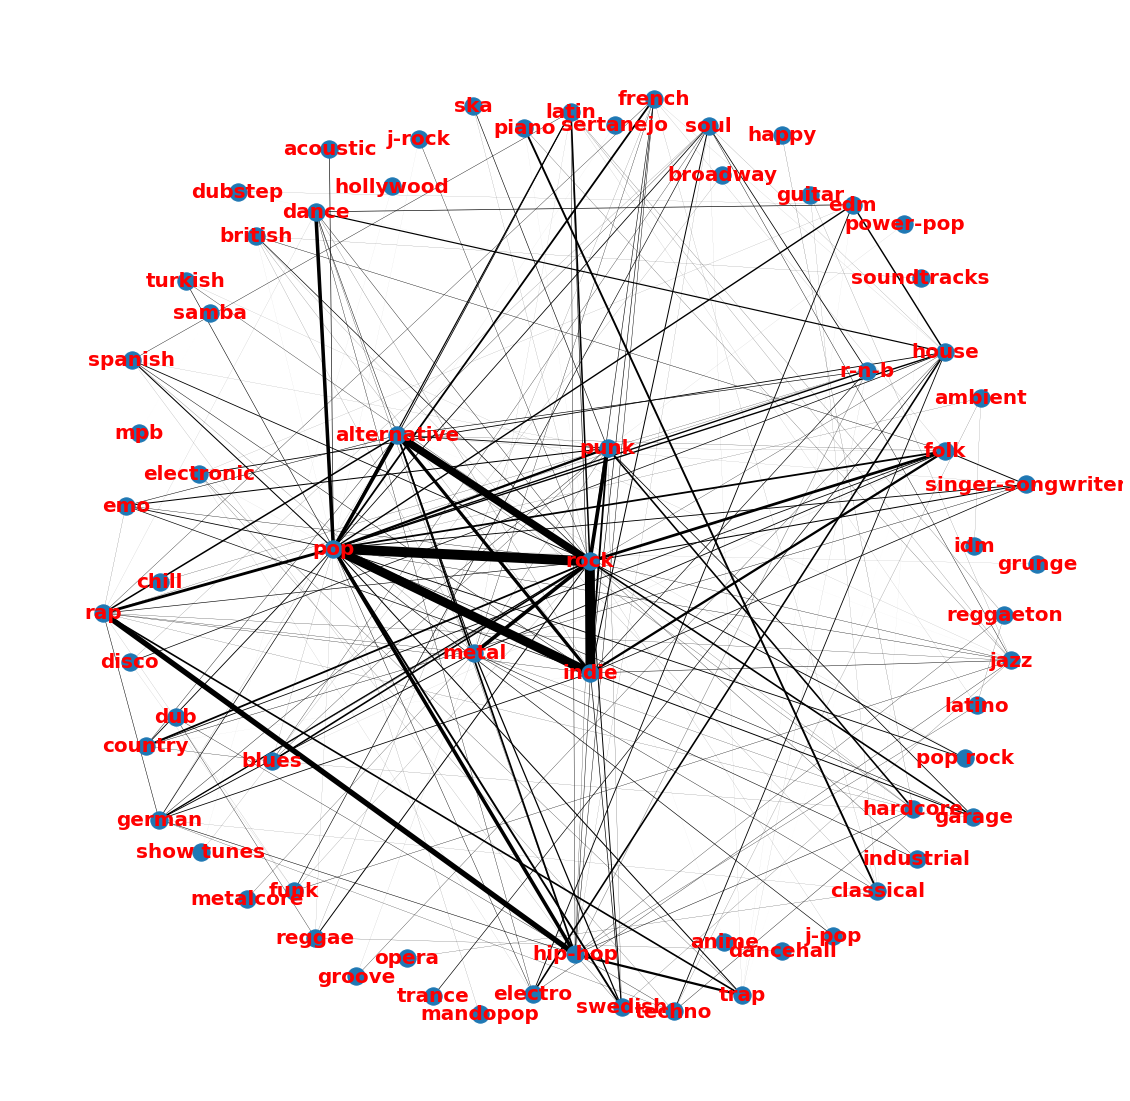

In [35]:
def plot_graph(G, to_file=False, file_name=None):
    
    G.remove_nodes_from(list(nx.isolates(G)))

    pos = nx.spring_layout(G, k=20/math.sqrt(G.order()));
    plt.figure(3,figsize=(20,20)) 
    nx.draw_networkx_nodes(G, pos);
    #nx.draw_networkx_edges(G, pos, width=2, arrowsize=30);#, alpha=0.3);
    for edge in G.edges(data=0):
        nx.draw_networkx_edges(G_artist_genres, pos, edgelist=[edge], width=edge[2])
    
    nx.draw_networkx_labels(G, pos, font_size=20, font_color='red', font_weight='bold')

    plt.axis("off")
    
    if to_file:
        plt.savefig(os.path.join('figs',f'06_G_{file_name}.png'), bbox_inches='tight')
    
    plt.show()
plot_graph(G_artist_genres, to_file=True, file_name='artist_genres')

### Analyze collocation of genres per track

In [36]:
tracks_info['n_artists']= tracks_info['artist_id'].apply(lambda x: len(x))
tracks_info

,track_id,release_date,release_date_precision,artist_id,artist_name,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,genres,num_genres,genres_str,num_artists,release_month,release_year,n_artists
0,0yZPKwpGqeStYYjiRNTcPu,2017-05-05,day,[11wRdbnoYqRddKBrpHt4Ue],[Kasabian],0.511,0.9430,9.0,-4.276,1.0,...,0.1610,0.5750,122.967,"['rock', 'garage', 'pop', 'alternative', 'indie']",5,";rock,garage,pop,alternative,indie",1,5,2017,1
1,4ak7xjvBeBOcJGWFDX9w5n,2019-06-21,day,"[7jVv8c5Fj3E9VhNjxT4snq, 4kYSro6naA4h99UJvo89HB]","[Lil Nas X, Cardi B]",0.706,0.6790,9.0,-5.614,1.0,...,0.4650,0.6570,140.081,"['rap', 'dance', 'pop']",3,";rap,dance,pop",2,6,2019,2
2,3b7OgfU9SY8C7YBJgTKS74,2017-03-06,day,[2hcsKca6hCfFMwwdbFvenJ],[BTOB],0.696,0.9090,5.0,-3.547,0.0,...,0.4660,0.6450,117.010,['k-pop'],1,;k-pop,1,3,2017,1
3,2syhl7N2qR4IwhlI7vy5HP,2018-02-23,day,[62zLrboqOTPyozwi721CVy],[Lorenzo],0.845,0.6140,6.0,-5.830,1.0,...,0.0969,0.3280,139.682,"['hip-hop', 'rap', 'french', 'pop']",4,";hip-hop,rap,french,pop",1,2,2018,1
4,5Q0af66iZwvAvN1LiayTNJ,2017-01-13,day,[02G0wSA5mAINnHX3nTCaHi],[Baustelle],0.544,0.6110,9.0,-6.574,1.0,...,0.0895,0.0485,111.900,"['alternative', 'indie', 'pop']",3,";alternative,indie,pop",1,1,2017,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966719,5k2N84tO7V39kmWqMBku1T,1968-11-01,day,[7FIoB5PHdrMZVC3q2HE5MS],[George Harrison],0.136,0.0753,10.0,-22.024,1.0,...,0.1100,0.0396,83.671,"['rock', 'folk', 'singer-songwriter']",3,";rock,folk,singer-songwriter",1,11,1968,1
1966720,4KFIL87itsaRlSdCO1SKVg,2019-05-08,day,[086jKULFviWvDwM4evJgIP],[Josephine Wiggs],0.506,0.1120,0.0,-18.450,1.0,...,0.1020,0.0447,91.992,[],0,;,1,5,2019,1
1966721,4yu9BIIY5Cn9a9JfyZ4y22,2010-02-16,day,[3ViZST9PgFoieuOHY2GZMp],[Bear Hands],0.653,0.4590,0.0,-11.858,1.0,...,0.4490,0.7000,91.998,"['rock', 'alternative', 'indie', 'pop']",4,";rock,alternative,indie,pop",1,2,2010,1
1966722,7HHgPfm3p5dlQpwLLTjUQT,2009-11-23,day,[4tX2TplrkIP4v05BNC903e],[Tom Petty and the Heartbreakers],0.661,0.6490,2.0,-6.777,0.0,...,0.9750,0.7320,114.477,"['rock', 'folk', 'pop', 'singer-songwriter', '...",5,";rock,folk,pop,singer-songwriter,pop rock",1,11,2009,1


In [37]:
collab_tracks= tracks_info[tracks_info['n_artists']>1]
collab_tracks

,track_id,release_date,release_date_precision,artist_id,artist_name,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,genres,num_genres,genres_str,num_artists,release_month,release_year,n_artists
1,4ak7xjvBeBOcJGWFDX9w5n,2019-06-21,day,"[7jVv8c5Fj3E9VhNjxT4snq, 4kYSro6naA4h99UJvo89HB]","[Lil Nas X, Cardi B]",0.706,0.67900,9.0,-5.614,1.0,...,0.4650,0.657,140.081,"['rap', 'dance', 'pop']",3,";rap,dance,pop",2,6,2019,2
6,5ZbcYWBQWoCpuVip1fmeMY,2018-11-23,day,"[3CJKkU0XuElRT1z8rEtIYg, 6ytOHdKh4xt4YvF7tz8Zcv]","[Luciano, Kalash Criminel]",0.825,0.62600,4.0,-8.444,0.0,...,0.1010,0.642,142.995,"['german', 'hip-hop', 'rap', 'french', 'pop']",5,";german,hip-hop,rap,french,pop",2,11,2018,2
9,0fcq51a3gOI6gPvzc0YLsk,2019-03-15,day,"[246dkjvS1zLTtiykXe5h60, 757aE44tKEUQEqRuT6GnE...","[Post Malone, Roddy Ricch, Tyga]",0.797,0.64000,11.0,-6.272,0.0,...,0.2090,0.486,100.002,"['rap', 'trap', 'pop', 'rap', 'dance', 'hip-hop']",6,";rap,trap,pop,rap,dance,hip-hop",3,3,2019,3
13,3kf0ERnVuqQs62SIpj4HN8,2018-10-26,day,"[6S3KljEiIOWoLMUyZrkQUc, 5uJw4WCX5nYj4FHky9r1Ug]","[Marnik, SMACK]",0.475,0.91400,0.0,-4.255,0.0,...,0.2770,0.156,138.007,[],0,;,2,10,2018,2
16,3tDqEKKUs6gf8zMvSuLyLA,2020-02-28,day,"[5f7VJjfbwm532GiveGC0ZK, 4O15NlyKLIASxsJ0PrXPfz]","[Lil Baby, Lil Uzi Vert]",0.892,0.48600,11.0,-8.637,0.0,...,0.1460,0.535,120.998,"['hip-hop', 'rap', 'trap', 'rap', 'trap']",5,";hip-hop,rap,trap,rap,trap",2,2,2020,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966687,6X2jYZpOrXiDXpOvQGcvsU,2015-02-04,day,"[2EWXgN0xWOnbqJOxa9pWNO, 0Pt3k7cpeOysqGGiw3tQcS]","[SawanoHiroyuki[nZk], mizuki]",0.536,0.92900,8.0,-4.829,1.0,...,0.2190,0.593,157.998,['anime'],1,;anime,2,2,2015,2
1966700,4F2faUgJBqsrgA51Lz6dNZ,2022-01-08,day,"[1Uff91EOsvd99rtAupatMP, 1p0J5PXJQMVqk5uVV4T1ja]","[Claude Debussy, Seong-Jin Cho]",0.295,0.00642,1.0,-36.008,0.0,...,0.0610,0.121,77.235,"['classical', 'classical', 'piano']",3,";classical,classical,piano",2,1,2022,2
1966705,0h9bMMjrFaNJP5oWMq7xPy,2018-10-19,day,"[1GGaiTLrRiVRnTdJygL1Yq, 6q8DZBLBYqEUdKZl54sqG...","[LOWFi, Jayy Grams, Hayelo, Von Wilda]",0.723,0.72900,0.0,-4.701,1.0,...,0.1030,0.909,89.970,['hip-hop'],1,;hip-hop,4,10,2018,4
1966707,7iqZMtyAQrp5CnIteoonl1,1999-01-01,day,"[7rPqFVgJYARiFsLDlN6W6y, 5ReVxzuREWusYE4ovnMbBn]","[Toquinho, Paulinho Nogueira]",0.696,0.26000,2.0,-15.253,0.0,...,0.1100,0.271,119.838,"['mpb', 'samba', 'bossa nova', 'choro', 'viola...",6,";mpb,samba,bossa nova,choro,violao,violao clas...",2,1,1999,2


In [38]:
collab_genres={}
for i, track in tqdm(collab_tracks.iterrows()):
    artist_codes= track['artist_id']
    for a1, a2 in list(itertools.combinations(artist_codes, 2)):

        try:
            g_lst1= artist_info.loc[a1]['genres']
            g_lst2= artist_info.loc[a2]['genres']
            for g1 in g_lst1:
                g1_dict= collab_genres.get(g1,{})
                for g2 in g_lst2:
                    v= g1_dict.get(g2,0)
                    v= v+1
                    g1_dict[g2]=v

                collab_genres[g1]= g1_dict

            for g2 in g_lst2:
                g2_dict= collab_genres.get(g2,{})
                for g1 in g_lst1:
                    v= g2_dict.get(g1,0)
                    v= v+1
                    g2_dict[g1]=v

                collab_genres[g2]= g2_dict
                
        except:
            pass

0it [00:00, ?it/s]

In [39]:
collab_genres

{'german': {'hip-hop': 6968,
  'rap': 3069,
  'french': 286,
  'pop': 2751,
  'german': 10692,
  'trap': 508,
  'turkish': 215,
  'house': 2030,
  'dance': 1025,
  'edm': 654,
  'electro': 400,
  'indie': 605,
  'folk': 132,
  'rock': 883,
  'alternative': 1125,
  'swedish': 297,
  'soul': 102,
  'techno': 988,
  'trance': 793,
  'reggae': 314,
  'scandipop': 10,
  'r-n-b': 155,
  'country': 14,
  'latin': 113,
  'reggaeton': 64,
  'acoustic': 33,
  'industrial': 47,
  'electronic': 456,
  'austropop': 2,
  'partyschlager': 22,
  'pop rock': 29,
  'latino': 16,
  'basshall': 10,
  'singer-songwriter': 158,
  'emo': 5,
  'psychokore': 16,
  'jazz': 867,
  'hardcore': 84,
  'schlager': 32,
  'dancehall': 44,
  'british': 672,
  'classic schlager': 21,
  'jump up': 14,
  'garage': 26,
  'neo mellow': 1,
  'punk': 112,
  'groove': 25,
  'metalcore': 27,
  'metal': 176,
  'europop': 8,
  'indiecoustica': 3,
  'melodic drill': 1,
  'hands up': 51,
  'classical': 5792,
  'piano': 1009,
  'dar

In [40]:
collab_genres_df= pd.DataFrame(collab_genres)
collab_genres_stacked= collab_genres_df.stack().reset_index()
collab_genres_stacked

,level_0,level_1,0
0,hip-hop,german,6968.0
1,hip-hop,hip-hop,93008.0
2,hip-hop,rap,56072.0
3,hip-hop,french,3203.0
4,hip-hop,pop,43826.0
...,...,...,...
38423,bass music,miami bass,1.0
38424,miami bass,bass music,1.0
38425,microtonal,xenharmonic,1.0
38426,musica piauiense,hi-nrg,1.0


In [41]:
collab_genres_stacked.describe()

,0
count,38428.000000
mean,78.131415
std,1156.814731
min,1.000000
25%,1.000000
50%,2.000000
75%,8.000000
max,93008.000000


In [42]:
collab_genres_stacked= collab_genres_stacked[collab_genres_stacked[0]>500]
collab_genres_stacked[0]=(collab_genres_stacked[0]-collab_genres_stacked[0].min())/(collab_genres_stacked[0].max()-collab_genres_stacked[0].min())
collab_genres_stacked[0]=collab_genres_stacked[0]*10
collab_genres_stacked

,level_0,level_1,0
0,hip-hop,german,0.698982
1,hip-hop,hip-hop,10.000000
2,hip-hop,rap,6.007178
3,hip-hop,french,0.291981
4,hip-hop,pop,4.683372
...,...,...,...
26173,sertanejo,sertanejo,0.020107
26551,samba,pagode,0.034268
26555,samba,mpb,0.152423
26560,samba,samba,0.120641


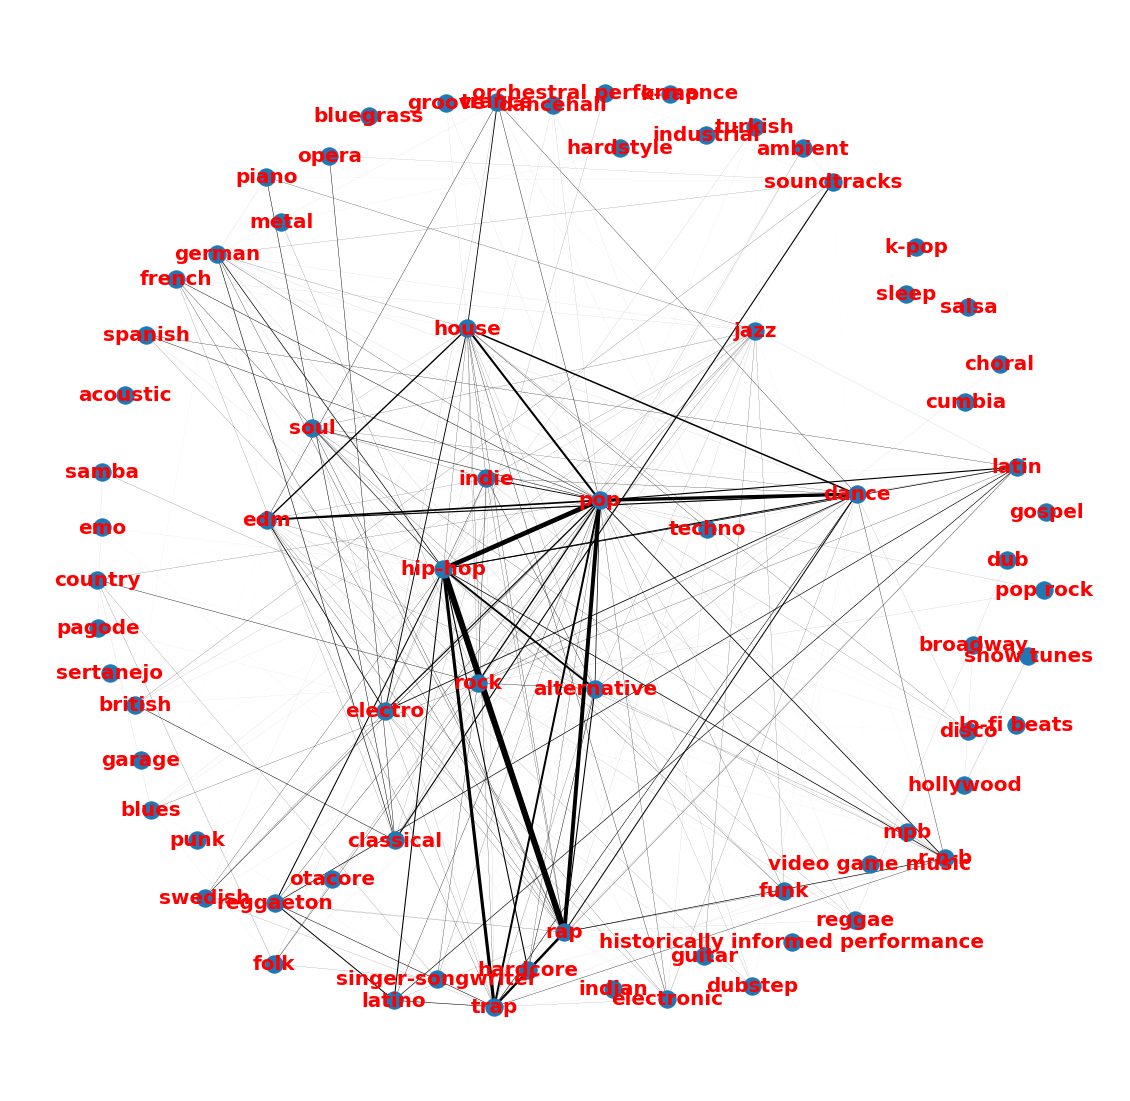

In [43]:
G_collab_genres=nx.from_pandas_edgelist(collab_genres_stacked, 'level_0', 'level_1', 0)
plot_graph(G_collab_genres, to_file=True, file_name='collab_genres')

### Calculate entropy

In [44]:
SPOTIPY_CLIENT_ID=['e1be06382c2d486fb229713b05850f64',
                   '67ac6bda2f78458f8553018c3082340b',
                   'e1a52feaafdd43ad9eff6dccd21a966e',
                   'a4fdae2cec0c4755bd305bc64a0aa7ea',
                   '91dbf78e2bc34a2f87464f5fdd27faa9',
                   '5e9ea2ed76c14333919dda3094056355',
                   '38980db96ebb4f70b8875e51ec43936a',
                   '0e3d3bc703714da4ae3c7056435fa7f4',
                  '470500d793ae4e10ac394e655b542432',
                    '933647a0ae0344c1a01d3f7f4d512cb0']
SPOTIPY_CLIENT_SECRET=['412a96bba9444861874dbe27bfe13084',
                       'e9da73b0c4a849b8a62f726c3d015811',
                       '7ec98fe3c4be48dd818fcc3704c461bf',
                       '82c0243a290340c8b1b06f0de595622e',
                       '64c6ad405e8744ed8a3009a58e36e672',
                       '01e7bba1e37d4c6b8710f81a3ca49725',
                       '4acc1efc8e4a4265bda6be4594329c83',
                       '2aebaed63e55430c915f6be24ace0c9e',
                       'c110cbdd33ab49fca353046162c9ecfe',
                      'f482e0a7c8314b9d95d8719996853aef']

n_spotify_clients=len(SPOTIPY_CLIENT_ID)
client_index=8
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID[client_index], 
                                                      client_secret=SPOTIPY_CLIENT_SECRET[client_index])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager, requests_timeout= 5)
all_genres = sp.recommendation_genre_seeds()

In [45]:
all_genres= all_genres['genres']

In [46]:
norm_collab_genres_df= collab_genres_df.div(collab_genres_df.sum(axis=1), axis=0).fillna(0)
norm_artist_genres_df= artist_genres_collocation_df.div(artist_genres_collocation_df.sum(axis=1), axis=0).fillna(0)

In [47]:
norm_collab_genres_df

,german,hip-hop,rap,french,pop,trap,dance,rock,salsa,reggaeton,...,sacred steel,raboday,kayokyoku,antilliaanse folklore,swing italiano,indonesian shoegaze,southeast asian post-rock,grungegaze,american oi,haitian traditional
hip-hop,0.020101,0.268299,0.161750,0.009240,0.126424,0.086518,0.029320,0.009349,0.000288,0.029242,...,0.0,0.000003,0.0,0.000003,0.000000,0.0,0.0,0.000003,0.0,0.0
rap,0.012615,0.230474,0.211476,0.011850,0.151449,0.090501,0.040598,0.010802,0.000140,0.005430,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000004,0.0,0.0
french,0.009985,0.111825,0.100653,0.198652,0.166638,0.005621,0.015012,0.025591,0.000000,0.000489,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
pop,0.006995,0.111429,0.093682,0.012135,0.221098,0.048049,0.077428,0.031726,0.000516,0.008284,...,0.0,0.000003,0.0,0.000000,0.000003,0.0,0.0,0.000003,0.0,0.0
german,0.218601,0.142463,0.062747,0.005847,0.056245,0.010386,0.020956,0.018053,0.000061,0.001308,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bass music,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
miami bass,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
microtonal,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
musica piauiense,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0


In [48]:
norm_artist_genres_df

,german,metal,rock,pop,alternative,country,singer-songwriter,pop rock,french,indie,...,sped up,turkce remix,russian hyperpop,bronx drill,melodic drill,musica coahuilense,drill espanol,dutch drill,israeli mediterranean,mizrahi
432hz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8-bit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a cappella,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abstract,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zolo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zouglou,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zouk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zouk riddim,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
common_genres_index= set(norm_artist_genres_df.index).intersection(set(norm_collab_genres_df.index))
common_genres_index= common_genres_index.intersection(set(all_genres))
common_genres_cols= set(norm_artist_genres_df.columns).intersection(set(norm_collab_genres_df.columns))
common_genres_cols= common_genres_cols.intersection(set(all_genres))


In [50]:
len(common_genres_index), len(common_genres_cols)

(89, 89)

In [51]:
from scipy.stats import entropy

entropy_track_artist=[]
norm_track_df= norm_collab_genres_df.loc[common_genres_index]
norm_track_df= norm_track_df[common_genres_cols]

norm_artist_df= norm_artist_genres_df.loc[common_genres_index]
norm_artist_df= norm_artist_df[common_genres_cols]


for g in norm_track_df.index:

    g1_dist= norm_track_df.loc[g].values
    g2_dist= norm_artist_df.loc[g].values
    
    g1_dist= g1_dist[np.where(g2_dist>0)]
    g2_dist= g2_dist[g2_dist>0]
    try:
        e= entropy(g1_dist, g2_dist, base=len(g1_dist))
        if not np.isnan(e):
            entropy_track_artist.append((g,e))
    except:
        print(f'Error with genre {g}')

entropy_track_artist_df= pd.DataFrame(entropy_track_artist, columns='genre entropy'.split())
entropy_track_artist_df= entropy_track_artist_df.set_index('genre')
entropy_track_artist_df= entropy_track_artist_df.sort_index()
entropy_track_artist_df

,entropy
genre,
acoustic,0.094912
afrobeat,0.116951
alternative,0.163202
ambient,0.157264
anime,0.134040
...,...
swedish,0.180366
tango,0.192927
techno,0.103569


In [56]:
entropy_track_artist_df.index

Index(['acoustic', 'afrobeat', 'alternative', 'ambient', 'anime', 'bluegrass',
       'blues', 'breakbeat', 'british', 'cantopop', 'chill', 'classical',
       'club', 'comedy', 'country', 'dance', 'dancehall', 'disco', 'dub',
       'dubstep', 'edm', 'electro', 'electronic', 'emo', 'folk', 'forro',
       'french', 'funk', 'garage', 'german', 'gospel', 'goth', 'grindcore',
       'groove', 'grunge', 'guitar', 'happy', 'hardcore', 'hardstyle',
       'hip-hop', 'honky-tonk', 'house', 'idm', 'indian', 'indie',
       'industrial', 'iranian', 'j-idol', 'j-pop', 'j-rock', 'jazz', 'k-pop',
       'kids', 'latin', 'latino', 'malay', 'mandopop', 'metal', 'metalcore',
       'mpb', 'opera', 'pagode', 'party', 'piano', 'pop', 'power-pop', 'punk',
       'r-n-b', 'reggae', 'reggaeton', 'rock', 'rockabilly', 'romance', 'sad',
       'salsa', 'samba', 'sertanejo', 'singer-songwriter', 'ska', 'sleep',
       'soul', 'soundtracks', 'spanish', 'study', 'swedish', 'tango', 'techno',
       'trance', 

In [57]:
entropy_track_artist_df.loc['pop'], entropy_track_artist_df.loc['rock'], entropy_track_artist_df.loc['hip-hop']

(entropy    0.121974
 Name: pop, dtype: float64,
 entropy    0.130445
 Name: rock, dtype: float64,
 entropy    0.030191
 Name: hip-hop, dtype: float64)

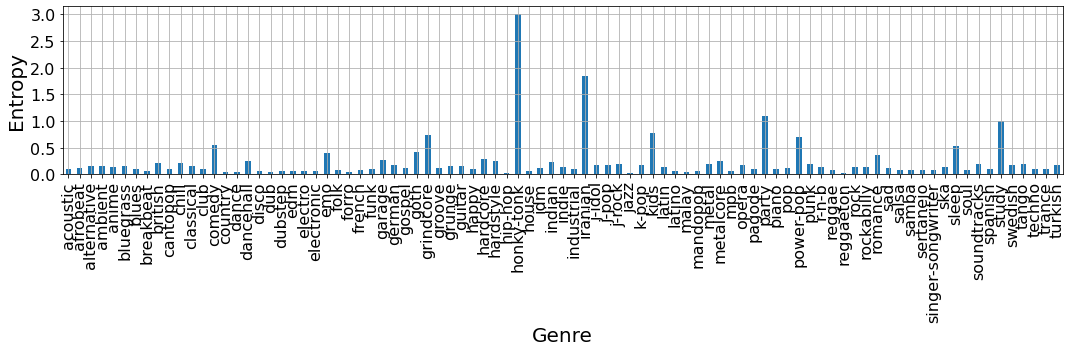

In [63]:
ax=entropy_track_artist_df.plot(kind='bar',grid=True, figsize=(15,5),legend=False, fontsize=16);
ax.set_xlabel('Genre', fontsize=20)
ax.set_ylabel('Entropy', fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join('figs',f'06_genres_entropy.png'), bbox_inches='tight')

### Analyze variation of the features between single and collaborative tracks

In [ ]:
audio_feat= tracks_info.loc[0]['danceability energy key loudness mode speechiness acousticness instrumentalness liveness valence tempo'.split()].values

In [ ]:
collab_audio_features= []
for i, track in tqdm(collab_tracks.iterrows()):
    audio_feat= track['danceability energy key loudness mode speechiness acousticness instrumentalness liveness valence tempo'.split()].values
    for artist in track['artist_id']:
        collab_audio_features.append(tuple(np.insert(audio_feat, 0, artist)))

In [ ]:
collab_audio_features_df= pd.DataFrame(collab_audio_features, columns= 'artist_id danceability energy key loudness mode speechiness acousticness instrumentalness liveness valence tempo'.split())
collab_audio_features_df

In [ ]:
collab_audio_feat_per_artist= collab_audio_features_df.groupby('artist_id').median()
collab_audio_feat_per_artist.head()

In [ ]:
single_audio_features= []
for i, track in tqdm(single_tracks.iterrows()):
    audio_feat= track['danceability energy key loudness mode speechiness acousticness instrumentalness liveness valence tempo'.split()].values
    for artist in track['artist_id']:
        single_audio_features.append(tuple(np.insert(audio_feat, 0, artist)))

In [ ]:
single_audio_features_df= pd.DataFrame(single_audio_features, columns= 'artist_id danceability energy key loudness mode speechiness acousticness instrumentalness liveness valence tempo'.split())
single_audio_features_df

In [ ]:
single_audio_feat_per_artist= single_audio_features_df.groupby('artist_id').median()
single_audio_feat_per_artist.head()

In [ ]:
diff_audio_feat_per_artist= collab_audio_feat_per_artist.div(single_audio_feat_per_artist)
diff_audio_feat_per_artist.head()

In [ ]:
diff_audio_feat_per_artist= diff_audio_feat_per_artist.dropna(axis=0)

In [ ]:
diff_audio_feat_per_artist.isna().sum().sum()

In [ ]:
diff_audio_feat_per_artist.head()

In [ ]:
diff_audio_feat_per_artist.shape

In [ ]:
mean_variance_audio_feat_df= diff_audio_feat_per_artist.median() -1
mean_variance_audio_feat_df

In [ ]:
ax= mean_variance_audio_feat_df.plot(kind='bar', figsize=(10,5), grid=True)
ax.set_ylabel('Rate of variation', fontsize=16);
ax.set_xlabel('Music genre', fontsize=16);
plt.tight_layout()
plt.savefig(os.path.join('figs',f'06_variation_features_single_vs_collab_tracks.png'), bbox_inches='tight')

### Analyze time-evolution of track features

In [ ]:
init_date='2004-01-01'
final_date='2021-12-31'

In [ ]:
tracks_info= pd.read_csv(os.path.join('data', 'generated', '05b_all_tracks_w_feat_and_genre.csv'),
                         converters={"artist_id": literal_eval, 'artist_name': literal_eval, 'genres':literal_eval}, 
                         parse_dates=['release_date'],
                         index_col=0)

In [ ]:
tracks_info= tracks_info[(tracks_info['release_date']>init_date) & (tracks_info['release_date']<=final_date)]
tracks_info= tracks_info[tracks_info['num_genres']>0]

tracks_info= tracks_info.reset_index(drop=True)
tracks_info['num_artists']= tracks_info['artist_id'].apply(lambda x:len(x))
tracks_info

In [ ]:
tracks_info= tracks_info.drop_duplicates('track_id')
tracks_info.shape

In [ ]:
collab_info= tracks_info[tracks_info['num_artists']>1]
collab_info.head()

### Generate artists' timeseries

In [ ]:
artist_feat_list={}

for i, track_inf in tqdm(tracks_info.iterrows()):
    for artist_id in track_inf['artist_id']:
        
        track_feat= track_inf['release_date danceability energy key loudness mode speechiness acousticness instrumentalness liveness valence tempo'.split()].values
        artist_ts= None
        if artist_id in artist_feat_list:
            artist_ts= artist_feat_list[artist_id]
            artist_ts= np.vstack((artist_ts, track_feat))
        else:
            artist_ts= track_feat
        artist_feat_list[artist_id]= artist_ts

In [ ]:
df= pd.DataFrame(artist_feat_list['7jVv8c5Fj3E9VhNjxT4snq'])
df= df.set_index(0)
df= df.sort_index()
df

#### Check timeseries are stationary

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
def adfuller_test2(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    return p_value <= signif

In [ ]:
stationary_lst={}
for artist_id, feat_list in tqdm(artist_feat_list.items()):
    df= pd.DataFrame(feat_list)
    if (df.shape[0]>5) and (df.shape[1]==12):
        df= df.set_index(0)
        df= df.sort_index()
        df= df.drop_duplicates()
        try:
            for i in range(1,12):
                is_stationary=adfuller_test2(df[i], signif=0.01)
                stationary_feat_lst= stationary_lst.get(i,None)
                if stationary_feat_lst is None:
                    stationary_lst[i]= is_stationary
                else:
                    stationary_lst[i]=np.vstack((stationary_feat_lst, is_stationary))        
        except:
            print(f"Error with {df.shape}")

In [ ]:
stationary_lst

In [ ]:
stationary_df_lst={}
for i in stationary_lst:
    stationary_df_lst[i]= pd.DataFrame(stationary_lst[i])

In [ ]:
for i in stationary_lst:
    stationary_df_lst[i].to_csv(os.path.join('data','generated', 'time_evol_study', f'feature_{i}.csv'))

--------------------------------------------

In [64]:
stationary_df_lst={}
for i in range(1,12):
    stationary_df_lst[i]= pd.read_csv(os.path.join('data','generated', 'time_evol_study', f'feature_{i}.csv'), index_col=0)

In [65]:
feats= 'danceability energy key loudness mode speechiness acousticness instrumentalness liveness valence tempo'.split()

stationary_results_=[]
for i, df in stationary_df_lst.items():
    counts= df.value_counts(normalize=True)
    stationary_results_.append((feats[i-1], counts[True], counts[False]))
    #print(i, df.value_counts(normalize=True))
stationary_results_df= pd.DataFrame.from_records(stationary_results_, columns='Features Stationary Non-stationary'.split())
stationary_results_df= stationary_results_df.set_index('Features')

In [66]:
stationary_results_df

,Stationary,Non-stationary
Features,,
danceability,0.483310,0.516690
energy,0.470226,0.529774
key,0.523715,0.476285
loudness,0.416905,0.583095
mode,0.514459,0.485541
speechiness,0.480132,0.519868
acousticness,0.469204,0.530796
instrumentalness,0.472717,0.527283
liveness,0.489760,0.510240


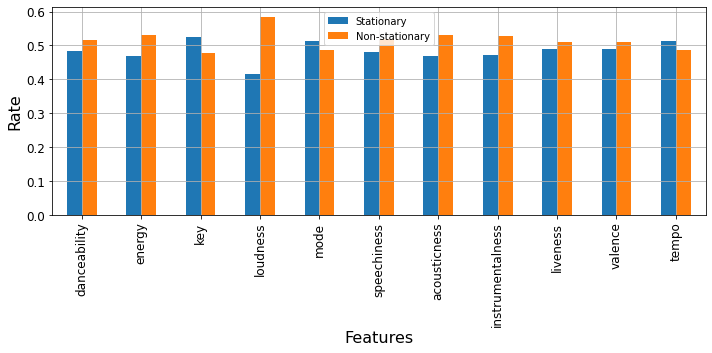

In [67]:
ax= stationary_results_df.plot(kind='bar', grid=True, figsize=(10,5), fontsize=12)
ax.set_xlabel('Features', fontsize=16)
ax.set_ylabel('Rate', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('figs',f'06_tracks_features_stationality.png'), bbox_inches='tight')

#### Autocorrelation

In [ ]:
auto_corr_lst={}
for artist_id, feat_list in tqdm(artist_feat_list.items()):
    df= pd.DataFrame(feat_list)
    #print(df.shape)
    if df.shape[1]==12:
        df= df.set_index(0)
        df= df.sort_index()
        df= df.drop_duplicates()
        for i in range(1,12):
            acorr = np.array(np.abs(sm.tsa.acf(df[i], nlags =12)))
            if acorr.shape[0]==13:
                auto_corr= auto_corr_lst.get(i,None)
                if auto_corr is None:
                    auto_corr_lst[i]= acorr
                else:
                    auto_corr_lst[i]=np.vstack((auto_corr, acorr))

In [ ]:
auto_corr_lst

In [ ]:
auto_corr_df_lst={}
for i in auto_corr_lst:
    auto_corr_df_lst[i]= pd.DataFrame(auto_corr_lst[i])
auto_corr_df_lst

In [ ]:
for i,auto_corr_df in auto_corr_df_lst.items():
    print(i)
    print(auto_corr_df.describe())
    print("-"*9)

In [ ]:
feats= 'danceability energy key loudness mode speechiness acousticness instrumentalness liveness valence tempo'.split()
for i,auto_corr_df in auto_corr_df_lst.items():
    ax=auto_corr_df[range(1,13)].mean().plot(grid=True, label=feats[i-1], legend=True, figsize=(15,5))
ax.set_xlabel('Lags', fontsize=16)
ax.set_ylabel('Absolute Autocorrelation', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('figs',f'06_autocorrelation.png'), bbox_inches='tight')
plt.show()

#### Partial autocorrelation

In [ ]:
pauto_corr_lst={}
for artist_id, feat_list in tqdm(artist_feat_list.items()):
    df= pd.DataFrame(feat_list)
    #print(df.shape)
    if df.shape[1]==12:
        df= df.set_index(0)
        df= df.sort_index()
        for i in range(1,12):
            n_lags= df.shape[0]//2
            try:
                acorr = np.array(np.abs(sm.tsa.pacf(df[i], nlags =6)))
                if acorr.shape[0]==7:
                    #print(acorr)
                    auto_corr= pauto_corr_lst.get(i,None)
                    if auto_corr is None:
                        pauto_corr_lst[i]= acorr
                    else:
                        pauto_corr_lst[i]=np.vstack((auto_corr, acorr))
            except:
                pass

In [ ]:
pauto_corr_lst

In [ ]:
pauto_corr_df_lst={}
for i in pauto_corr_lst:
    pauto_corr_df_lst[i]= pd.DataFrame(pauto_corr_lst[i])
pauto_corr_df_lst

In [ ]:
for i,pauto_corr_df  in pauto_corr_df_lst.items():
    print(i)
    print(pauto_corr_df.describe())
    print("-"*9)

In [ ]:
pauto_corr_df_lst

In [ ]:
feats= 'danceability energy key loudness mode speechiness acousticness instrumentalness liveness valence tempo'.split()
for i,auto_corr_df in pauto_corr_df_lst.items():
    ax=auto_corr_df[range(1,7)].mean().plot(grid=True, label=feats[i-1], legend=True, figsize=(15,5))
ax.set_xlabel('Lags', fontsize=16)
ax.set_ylabel('Absolute Partial Autocorrelation', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join('figs',f'06_partial_correlation.png'), bbox_inches='tight')
plt.show()

In [ ]:
print("That's all folks!")